# 09: Demonstration of MODFLOW 6 Groundwater Transport with a Voronoi Grid

MODFLOW 6 includes a Groundwater Transport (GWT) Model for simulation of solute transport through the subsurface.  The GWT Model can be used with structured or unstructured model grids.  The purpose of this example is to demonstrate the construction, running, and post-processing of a simple solute transport model.

The solute transport model is based on an existing flow model of the Freyberg example.  The flow model usesd a voronoi model grid to simulate steady-state conditions.  In this notebook, we create a transient solute transport model using the same voronoi grid that was used for flow.

The following steps are used in this notebook.
* Load the existing flow model into FloPy
* Plot the model grid
* Create the solute transport model
* Run the solute transport model with MODFLOW 6
* Create animations of the model results

### Imports

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import flopy
from flopy.utils.triangle import Triangle as Triangle

AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

### Load and Plot the Existing Flow Model

In [2]:
model_ws_load = "./data/voronoi/"
model_ws = "./temp/voronoi-gwt/"
name = "voronoi"
name_load = "project"

Load a few shapefiles with geopandas

In [3]:
river_shp = "data_project/Flowline_river.shp"
wells_shp = "data_project/pumping_well_locations.shp"

Load the existing voronoi groundwater flow model

In [4]:
%%capture
sim = flopy.mf6.MFSimulation.load(sim_ws=model_ws_load, sim_name=name)

NameError: name 'flopy' is not defined

Get the gwf model

In [5]:
gwf = sim.get_model()

NameError: name 'sim' is not defined

Assign a constant concentration condition to the x, y location of 550, 7900.  Use the `modelgrid.intersect` method to determine the cell number for the constant concentration condition.

In [6]:
gwf.modelgrid.intersect(550, 7900)

NameError: name 'gwf' is not defined

Plot the grid

In [7]:
gwf.modelgrid.plot()
ax = plt.gca()
ax.plot(550, 7900, marker="o", lw=0, color="red", )

NameError: name 'gwf' is not defined

### Create the Groundwater Transport Model

Get data from the GWF DISV package

In [8]:
nlay, ncpl = gwf.disv.nlay.array, gwf.disv.ncpl.array
nlay, ncpl

NameError: name 'gwf' is not defined

In [9]:
top, botm = gwf.disv.top.array, gwf.disv.botm.array
top.shape, botm.shape

NameError: name 'gwf' is not defined

In [10]:
nverts = gwf.disv.nvert.array
nverts

NameError: name 'gwf' is not defined

In [11]:
vertices, cell2d = gwf.disv.vertices.array, gwf.disv.cell2d.array

NameError: name 'gwf' is not defined

Create the GWT model

In [12]:
sim_gwt = flopy.mf6.MFSimulation(sim_name=name, sim_ws=model_ws)
tdis = flopy.mf6.ModflowTdis(sim_gwt, 
                             time_units="days",
                             perioddata=((10000.0, 100, 1.0),),
                            )
ims = flopy.mf6.ModflowIms(
    sim_gwt,
    linear_acceleration="bicgstab",
    outer_maximum=200,
    inner_maximum=100,
    print_option="all",
)

NameError: name 'flopy' is not defined

In [13]:
gwt = flopy.mf6.ModflowGwt(sim_gwt, modelname=name)

NameError: name 'flopy' is not defined

Create the GWT packages

In [14]:
dis = flopy.mf6.ModflowGwtdisv(
    gwt,
    length_units="feet",
    nlay=nlay,
    ncpl=ncpl,
    nvert=nverts,
    top=top,
    botm=botm,
    vertices=vertices,
    cell2d=cell2d,
)
ic = flopy.mf6.ModflowGwtic(gwt, strt=0.0)
adv = flopy.mf6.ModflowGwtadv(
    gwt, 
    scheme="tvd",
)
dsp = flopy.mf6.ModflowGwtdsp(gwt, alh=50.0, ath1=5)
mst = flopy.mf6.ModflowGwtmst(gwt, porosity=0.2)
pd = [
    ("GWFHEAD", f"../../{model_ws_load}{name_load}.hds", None),
    ("GWFBUDGET", f"../../{model_ws_load}{name_load}.cbc", None),
]
fmi = flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)
ssm = flopy.mf6.ModflowGwtssm(gwt)
cnc = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=[(0, 2027, 100.)])

oc = flopy.mf6.ModflowGwtoc(
    gwt,
    concentration_filerecord=f"{name}.ucn",
    saverecord=[("CONCENTRATION", "ALL"),],
    printrecord=[("BUDGET", "ALL")],
)
# write the model datasets
sim_gwt.write_simulation()

NameError: name 'flopy' is not defined

### Run the Solute Transport Model

In [15]:
sim_gwt.run_simulation()

NameError: name 'sim_gwt' is not defined

### Post-process the results

Use `gwt.output.` method to get the concentrations. Make an animation the concentrations using `flopy.plot` methods.

In [16]:
head = gwf.output.head().get_data()
spdis = gwf.output.budget().get_data(text="DATA-SPDIS")[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    spdis, gwf, head=gwf.output.head().get_data(),
)

NameError: name 'gwf' is not defined

In [17]:
times = gwt.output.concentration().get_times()

NameError: name 'gwt' is not defined

NameError: name 'times' is not defined

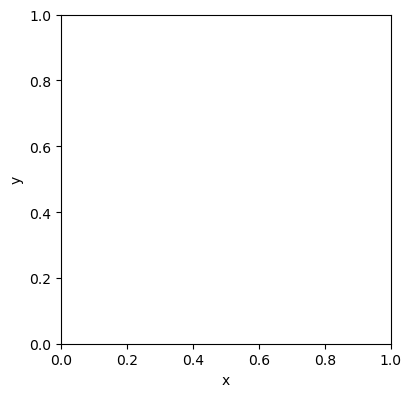

In [18]:
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(figsize=(4, 6), constrained_layout=True)
ax.set_aspect(1)
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
title = ax.set_title(f"Time = {times[0]} days")

# plot persistent items
vmin, vmax = 1e-3, 100.
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

pmv = flopy.plot.PlotMapView(gwt, ax=ax)
pmv.plot_grid(lw=0.5, color="0.5")
pmv.contour_array(
    head, 
    levels=np.linspace(0, 30, 30), 
    tri_mask=True,
    linestyles="-",
    colors="blue",
    linewidths=0.5,
)
ca_dict = {
    "vmin": vmin,
    "vmax": vmax,
    "norm": norm,
    "masked_values": [0],
}
conc_alldata = gwt.output.concentration().get_alldata()
c = conc_alldata[0]
c[c < vmin] = 0.
cont = pmv.plot_array(c, **ca_dict)
clb = fig.colorbar(
    cont, 
    shrink=0.5, 
)

def animate(i):
    c = conc_alldata[i].flatten()
    c[c < vmin] = 0.
    cont.set_array(c)
    title = ax.set_title(f"Time = {times[i]} days")
    return cont

import matplotlib.animation
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=conc_alldata.shape[0])
plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())

# can use this command to write animation to file
#ani.save("voronoi-conc-animation.avi")

In [19]:
line = [(0, 8100), (2000, 8300), (5000, 8100)]
xs = flopy.plot.PlotCrossSection(model=gwt, line={"line": line}) 
cb = xs.plot_array(conc_alldata[-1],
                   head=gwf.output.head().get_data(),
                   norm=norm,
                   masked_values=[0], vmin=vmin, vmax=vmax)
xs.plot_grid(lw=0.5, color="0.5")
plt.colorbar(cb, ax=xs.ax)


NameError: name 'flopy' is not defined